# 4. Сверточные нейронные сети.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г.

In [134]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [135]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [136]:
torch.set_warn_always(True)

plt.style.use("science")
sns.set_theme()

plt.rcParams["figure.figsize"] = (8, 4)

In [137]:
DATA_DIR = Path("data/")

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [138]:
train_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

train_data.data.size(), train_data.targets.size(), len(train_data.classes)

(torch.Size([60000, 28, 28]), torch.Size([60000]), 10)

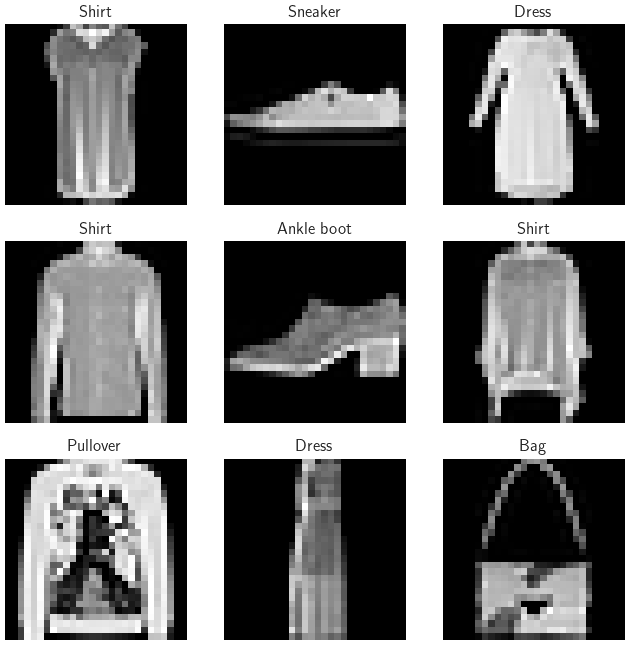

In [139]:
labels = {v: k for k, v in train_data.class_to_idx.items()}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

Архитектура модели взята из **[Introduction to PyTorch](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html#define-the-class)**:

In [140]:
class NeuralNetwork(nn.Module):

    def __init__(self, in_features: int, out_features: int):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)

In [141]:
def train_loop(dataloader, model: nn.Module, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [142]:
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

Функция [потерь](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#loss-function) и [оптимизатор](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#optimizer) взяты из **Introduction to PyTorch**:

In [143]:
torch.manual_seed(0)

# количество входных параметров модели определяется как произведение:
# кол-во цветовых каналов * ширина картинки * высота картинки
net = NeuralNetwork(1 * 28 * 28, 10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [102]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, net, loss_fn, optimizer)
    # test_loop(test_dataloader, net, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.305311  [    0/60000]
loss: 2.298351  [ 6400/60000]
loss: 2.277986  [12800/60000]
loss: 2.275867  [19200/60000]
loss: 2.254383  [25600/60000]
loss: 2.230111  [32000/60000]
loss: 2.230497  [38400/60000]
loss: 2.198087  [44800/60000]
loss: 2.203432  [51200/60000]
loss: 2.172682  [57600/60000]
Epoch 2
-------------------------------
loss: 2.174578  [    0/60000]
loss: 2.168032  [ 6400/60000]
loss: 2.111102  [12800/60000]
loss: 2.124137  [19200/60000]
loss: 2.076458  [25600/60000]
loss: 2.022723  [32000/60000]
loss: 2.042090  [38400/60000]
loss: 1.967449  [44800/60000]
loss: 1.975448  [51200/60000]
loss: 1.898244  [57600/60000]
Epoch 3
-------------------------------
loss: 1.935570  [    0/60000]
loss: 1.908893  [ 6400/60000]
loss: 1.791451  [12800/60000]
loss: 1.824325  [19200/60000]
loss: 1.725939  [25600/60000]
loss: 1.674582  [32000/60000]
loss: 1.685523  [38400/60000]
loss: 1.587119  [44800/60000]
loss: 1.613399  [51200/60000]
loss: 1.49

In [98]:
# X=torch.Size([64, 1, 28, 28]), pred=torch.Size([64, 10]), y=torch.Size([64])

In [103]:
test_loop(test_dataloader, net, loss_fn)

Test Error: 
 Accuracy: 71.2%, Avg loss: 0.778388 



In [108]:
train_loop(train_dataloader, net, loss_fn, optimizer)

torch.Size([64, 784])
loss: 0.716037  [    0/60000]
torch.Size([64, 784])
loss: 0.801836  [ 6400/60000]



KeyboardInterrupt



SyntaxError: incomplete input (2231165597.py, line 1)

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:16<00:00, 81.74it/s]


### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)